In [1]:
%run ../config/init.py
HTML(hide_code_str())

# Cloud transcriptome annotation
 
__Dataset Name__: PRJNA320545  
__Author__: Roberto Vera Alvarez  
__Email__: veraalva@ncbi.nlm.nih.gov

__Created Date__: 03/24/2020  

### Introduction

The annotation of mRNA transcripts with functional and biological processes is an important step in developing an understanding of the biological complexity of an organism. Annotation is a complex process that requires the integration of multiple biological databases with several software tools.
 
A review of published manuscripts since 2012$^{1-9}$ reveals that many pipelines have a common core component which is the NCBI BLAST sequence comparison tool$^{10}$. BLAST is used to align an assembled transcriptome against annotated databases of nucleotides or proteins. After an assembly, these alignments are the first step to identifying close and/or distant homologous genes, proteins, and functional domains that could be cross-referenced with other public databases, such as Gene Ontology$^{11}$, to generate new annotations on an unkown set of sequeneces.
 
Our study is based on a workflow for [transcriptome annotation](https://github.com/ncbi/cwl-ngs-workflows-cbb/blob/master/workflows/Annotation/transcriptome_annotation.cwl). 

<img src="../doc/transcriptome_annotation.cwl.png" width="600" height="400"/>

This workflow is comprised of five steps that include the key steps required for the transcriptome annotation. First, TransDecoder$^{12}$ is used to generate all open reading frames (ORFs) from the transcripts. Then, BLASTP and RPS-BLAST are used to generate a list of homologous proteins and conserved domains. BLASTP uses the BLAST non-redundant database (nr), and RPS-BLAST uses the NCBI Conserved Domain Database (CDD)$^{13}$. In parallel, BLASTN and RPST-BLASTN are executed, using the BLAST nucleotide database (nt) and the NCBI CDD database, respectively. These steps generate a list of homologous genes and conserved domains. The workflow uses as input a FASTA file (query), with multiple transcripts to process. We also analyzed variations in the query size (i.e. the number of transcripts (sequences) in the file).

We used the transcriptome assembled from a public BioProject (ID [PRJNA320545](https://www.ncbi.nlm.nih.gov/bioproject/PRJNA320545)) from the organism, Opuntia streptacantha, the prickly pear. The transcriptome includes 474,563 transcripts. From this pool of transcripts, three types of query files (FASTA files) were randomly generated, with 2,000, 6,000, and 10,000 transcripts in each. For each query size, 20 different files were generated and processed independently.

### Cloud platforms

We tested our pipeline on two cloud providers, the Google Cloud Platorm (GCP) and on the Amazon Web Servises (AWS) using similar machine types. First and second generation machines were tested with 16, 32 and 64 CPUs. First generation GCP machines are labbeled N1 and second generation N2. First generatrion AWS machines are labeled M5D and second generation M5DN.
 
Times and cost were analyzed and shown in the plots. First, total billed time and cost with all tested configurations. Then, the time and cost for instance creation, setup and release. Finally, times and cost for the transfer of the BLAST databases, currently 342 GB (including nt, nr and CDD) were calculated.

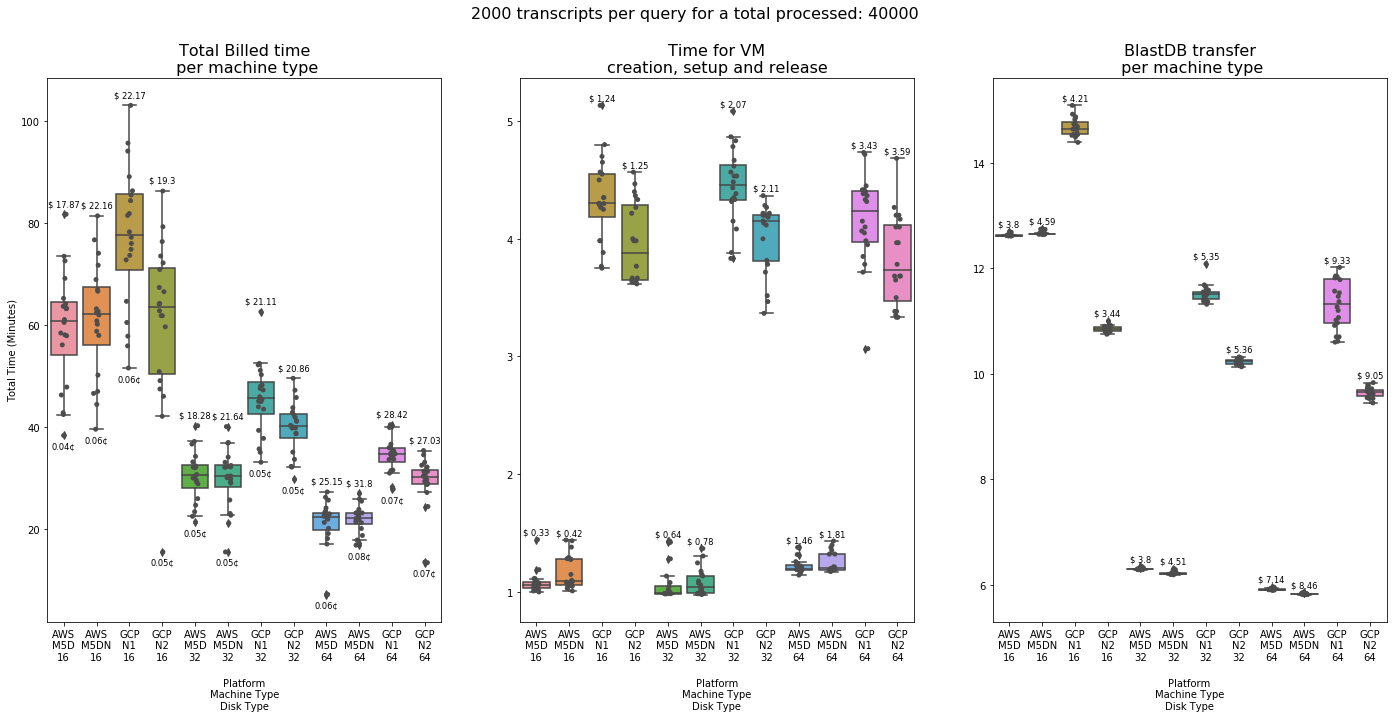

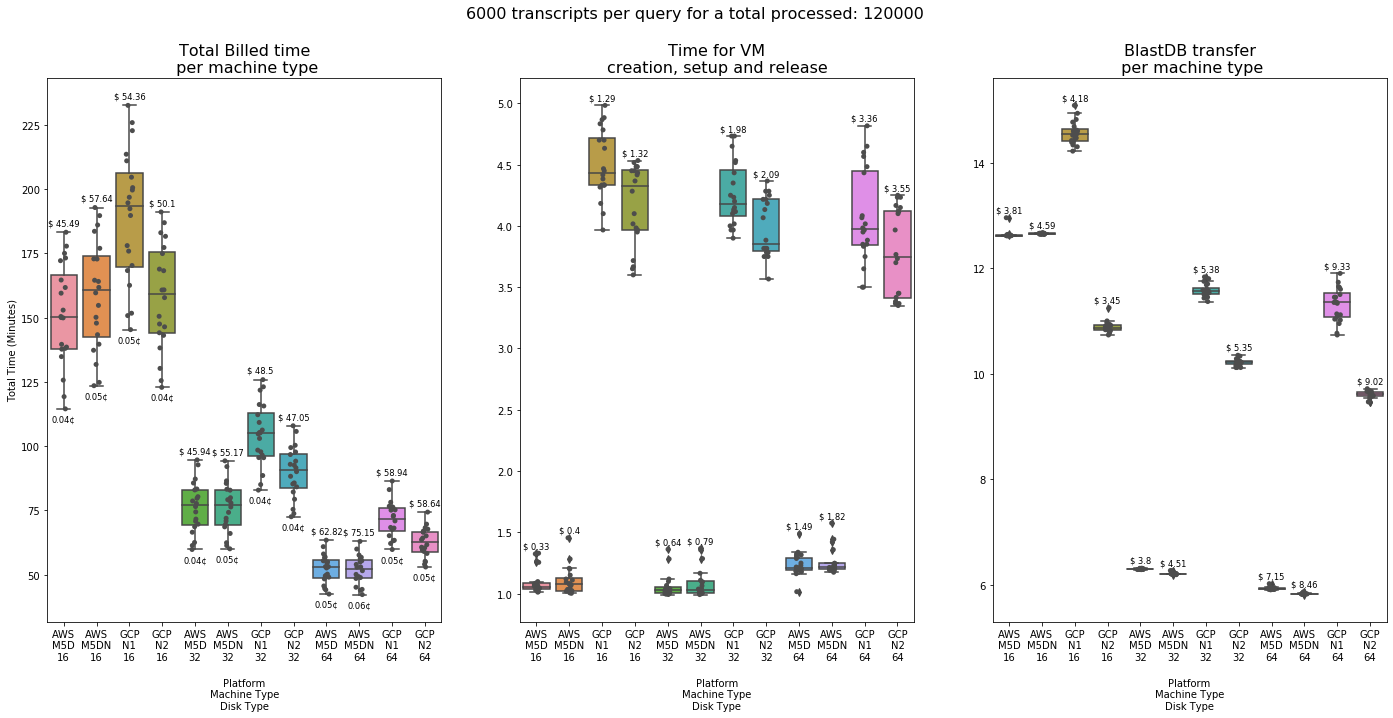

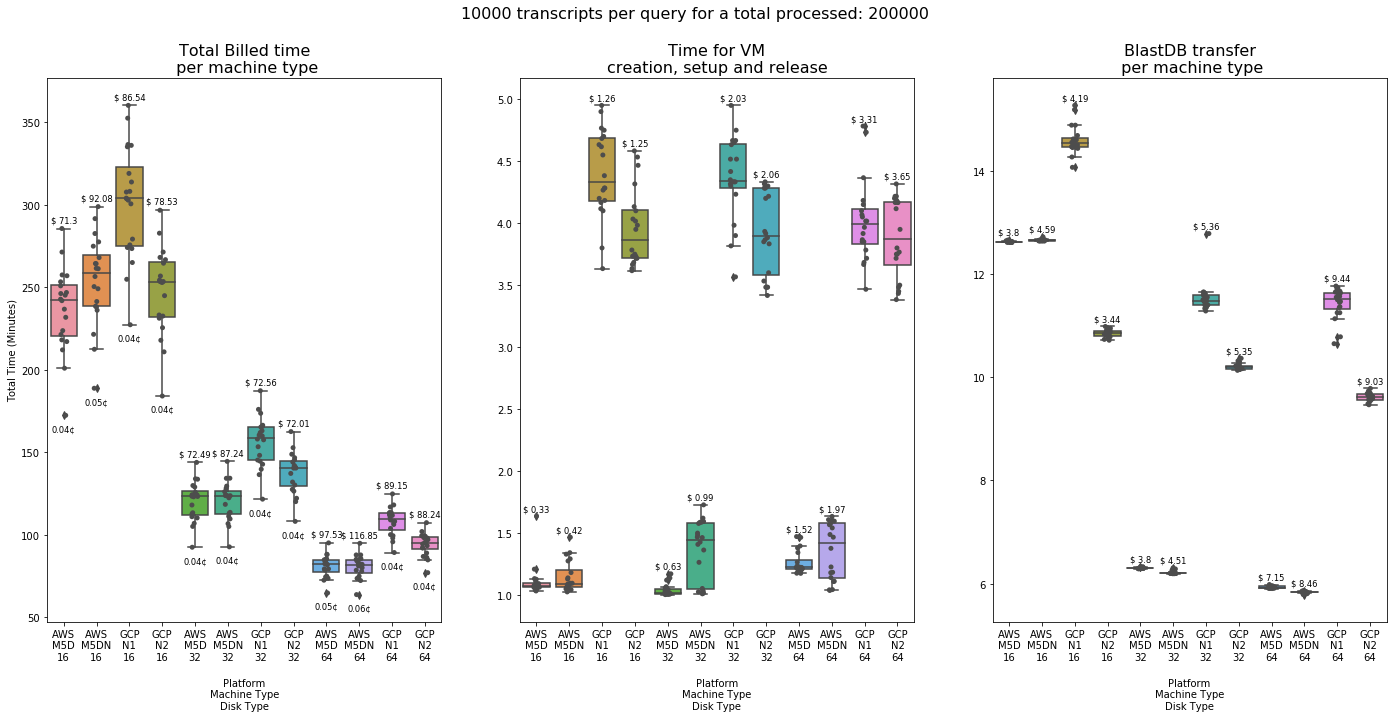

In [2]:
QUERY_SIZES = [2000, 6000, 10000]

# Prices from 03/04/2020
PRICE = {
    'n1':{
        16: 0.861,
        32: 1.393,
        64: 2.475
    },
    'n2':{
        16: 0.951,
        32: 1.572,
        64: 2.816
    },
    'm5d':{
        16: 0.904,
        32: 1.808,
        64: 3.616
    },
    'm5dn':{
        16: 1.088,
        32: 2.176,
        64: 4.352
    }    
}


result_dir = os.path.join(RESULTS, DATASET)
if not os.path.exists(result_dir):
    os.mkdir(result_dir) 
os.chdir(result_dir)

for q in QUERY_SIZES:
    q_dir = os.path.join(result_dir, str(q))
    os.chdir(q_dir)
    gcp = pandas.read_csv('gcp_total.tsv', sep='\t')
    aws = pandas.read_csv('aws_total.tsv', sep='\t')
    df_total = pandas.concat([gcp, aws])
    
    new = df_total['Platform'].str.split("\n", n = 2, expand = True)
    df_total['cloud'] = new[0]
    df_total['machine'] = new[1]
    df_total['cpu'] = new[2]
    df_total = df_total.sort_values(by=['cpu', 'machine', 'cloud'])    

    gcp = pandas.read_csv('gcp_blast.tsv', sep='\t')
    aws = pandas.read_csv('aws_blast.tsv', sep='\t')
    df_blast = pandas.concat([gcp, aws])
    
    new = df_blast['Platform'].str.split("\n", n = 2, expand = True)
    df_blast['cloud'] = new[0]
    df_blast['machine'] = new[1]
    df_blast['cpu'] = new[2]
    df_blast = df_blast.sort_values(by=['cpu', 'machine', 'cloud'])    

    gcp = pandas.read_csv('gcp_creation.tsv', sep='\t')
    aws = pandas.read_csv('aws_creation.tsv', sep='\t')
    df_creation = pandas.concat([gcp, aws])
    
    new = df_creation['Platform'].str.split("\n", n = 2, expand = True)
    df_creation['cloud'] = new[0]
    df_creation['machine'] = new[1]
    df_creation['cpu'] = new[2]
    df_creation = df_creation.sort_values(by=['cpu', 'machine', 'cloud'])    
    
    fig, axs = plt.subplots(figsize=(24,10), ncols=3)

    fig.suptitle(locale.format_string("%d", int(q), grouping=True)
                         + ' transcripts per query for a total processed: ' 
                         + locale.format_string("%d", int(q) * 20, grouping=True)
                 + '\n\n', fontsize=16)

    j=0

    top = []
    low = []
    billed = []
    cost = []
    for p in df_total['Platform'].unique():
        f = p.lower().split('\n')
        top.append(df_total[df_total['Platform'] == p]['Time'].max())
        low.append(df_total[df_total['Platform'] == p]['Time'].min())
        billed.append('$ {}'.format(round(df_total[df_total['Platform'] == p]['Time'].sum()/60 * PRICE[f[1]][int(f[2])], 2)))
        cost.append('{:.2f}¢'.format(df_total[df_total['Platform'] == p]['Time'].sum()/60 * PRICE[f[1]][int(f[2])] * 100/(int(q) * 20)))


    box_plot = sns.boxplot(x="Platform", y="Time", data=df_total, ax=axs[j])
    
    top_tick = 1.6
    low_tick = 2.6
    if q == 6000:
        top_tick += 1.0
        low_tick += 2.4
    elif q == 10000:
        top_tick += 2.2
        low_tick += 7.2

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,top[xtick] + top_tick,billed[xtick], 
                horizontalalignment='center',size='small',weight='normal')

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,low[xtick] - low_tick,cost[xtick], 
                horizontalalignment='center',size='small',weight='normal')

    sns.stripplot(x="Platform", y="Time", data=df_total, jitter=True, color=".3", ax=axs[j])
    axs[j].set_ylabel("Total Time (Minutes)")
    axs[j].set_xlabel("\nPlatform\nMachine Type\nDisk Type")
    axs[j].set_title("Total Billed time\n per machine type", fontsize=16)

    j = 1

    top = []
    billed = []
    for p in df_creation['Platform'].unique():
        f = p.lower().split('\n')
        top.append(df_creation[df_creation['Platform'] == p]['Time'].max())
        billed.append('$ {}'.format(round(df_creation[df_creation['Platform'] == p]['Time'].sum()/60 * PRICE[f[1]][int(f[2])], 2)))
        
    box_plot = sns.boxplot(x="Platform", y="Time", data=df_creation, ax=axs[j])

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,top[xtick] + 0.04,billed[xtick], 
                horizontalalignment='center',size='small',weight='normal')

    sns.stripplot(x="Platform", y="Time", data=df_creation, jitter=True, color=".3", ax=axs[j])
    axs[j].set_ylabel("")
    axs[j].set_xlabel("\nPlatform\nMachine Type\nDisk Type")
    axs[j].set_title("Time for VM\ncreation, setup and release", fontsize=16)

    j = 2

    top = []
    billed = []
    for p in df_blast['Platform'].unique():
        f = p.lower().split('\n')
        top.append(df_blast[df_blast['Platform'] == p]['Time'].max())
        billed.append('$ {}'.format(round(df_blast[df_blast['Platform'] == p]['Time'].sum()/60 * PRICE[f[1]][int(f[2])], 2)))
        
    box_plot = sns.boxplot(x="Platform", y="Time", data=df_blast, ax=axs[j])

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,top[xtick] + 0.1,billed[xtick], 
                horizontalalignment='center',size='small',weight='normal')

    sns.stripplot(x="Platform", y="Time", data=df_blast, jitter=True, color=".3", ax=axs[j])
    axs[j].set_ylabel("")
    axs[j].set_xlabel("\nPlatform\nMachine Type\nDisk Type")
    axs[j].set_title("BlastDB transfer\n per machine type", fontsize=16)

    fig.savefig(os.path.join(DOC,'{}.png'.format(q)))

### References

1.	Al-Qurainy, F. et al. Comprehensive Stress-Based De Novo Transcriptome Assembly and Annotation of Guar (Cyamopsis tetragonoloba (L.) Taub.): An Important Industrial and Forage Crop. Int J Genomics 2019, 7295859, doi:10.1155/2019/7295859 (2019).
2.	Chabikwa, T. G., Barbier, F. F., Tanurdzic, M. & Beveridge, C. A. De novo transcriptome assembly and annotation for gene discovery in avocado, macadamia and mango. Sci Data 7, 9, doi:10.1038/s41597-019-0350-9 (2020).
3.	Ji, P. et al. Characterization of common carp transcriptome: sequencing, de novo assembly, annotation and comparative genomics. PLoS One 7, e35152, doi:10.1371/journal.pone.0035152 (2012).
4.	Torre, S. et al. RNA-seq analysis of Quercus pubescens Leaves: de novo transcriptome assembly, annotation and functional markers development. PLoS One 9, e112487, doi:10.1371/journal.pone.0112487 (2014).
5.	Carruthers, M. et al. De novo transcriptome assembly, annotation and comparison of four ecological and evolutionary model salmonid fish species. BMC Genomics 19, 32, doi:10.1186/s12864-017-4379-x (2018).
6.	Haas, B. J. et al. De novo transcript sequence reconstruction from RNA-seq using the Trinity platform for reference generation and analysis. Nat Protoc 8, 1494-1512, doi:10.1038/nprot.2013.084 (2013).
7.	Bryant, D. M. et al. A Tissue-Mapped Axolotl De Novo Transcriptome Enables Identification of Limb Regeneration Factors. Cell Rep 18, 762-776, doi:10.1016/j.celrep.2016.12.063 (2017).
8.	Vera Alvarez, R. et al. Workflow and web application for annotating NCBI BioProject transcriptome data. Database (Oxford) 2017, doi:10.1093/database/bax008 (2017).
9.	Gamez, R. M. et al. Banana (Musa acuminata) transcriptome profiling in response to rhizobacteria: Bacillus amyloliquefaciens Bs006 and Pseudomonas fluorescens Ps006. BMC Genomics 20, 378, doi:10.1186/s12864-019-5763-5 (2019).
10.	Altschul, S. F., Gish, W., Miller, W., Myers, E. W. & Lipman, D. J. Basic local alignment search tool. J Mol Biol 215, 403-410, doi:10.1016/S0022-2836(05)80360-2 (1990).
11.	Ashburner, M. et al. Gene ontology: tool for the unification of biology. The Gene Ontology Consortium. Nat Genet 25, 25-29, doi:10.1038/75556 (2000).
12.	Haas, B. & Papanicolaou, A. TransDecoder (Find Coding Regions Within Transcripts), <https://github.com/TransDecoder/TransDecoder/wiki> (2020).
13.	Yang, M., Derbyshire, M. K., Yamashita, R. A. & Marchler-Bauer, A. NCBI's Conserved Domain Database and Tools for Protein Domain Analysis. Curr Protoc Bioinformatics 69, e90, doi:10.1002/cpbi.90 (2020).
  